# Отток клиентов

Предоставленные данные имеют следующие поля:

Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Класс:
- Exited — факт ухода клиента

# 1. Подготовка данных

Для начала необходимо импортировать все необходимые библиотеки, а так же оключить предупреждения

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Как можно увидеть в данных присутствуют следущие проблемы: 
- Названия признаков написаны с большой буквы, что для меня немного неудобно
- Есть пропуски в столбце Tenure
- Присуствуют категориалные признаки, от которых необходимо изавится для обучения модели
- Необходимо проскейлить данные по столбцам Balance и EstimatedSalaryдля избежания выбросов

После чего эти данные необходимо разбить на выборки

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Для начала привожу названия признаков к нижнем регистру

In [5]:
df.columns = map(str.lower, df.columns)

После чего заполняю пропуски медианой, так как данный метод заполнения не принесет отклонений, которые я могу вызвать, заполнив пропуски синтетическими значениями

In [6]:
del df['rownumber']
del df['customerid']
del df['surname']

In [7]:
df.fillna(value=df['tenure'].median(), inplace=True)

После того кодирую категориальные признаки методом Ordinal Encoding (просто этот метод мне более симпатичен)

In [8]:
encoder = OrdinalEncoder()
df_encoded = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)

После кодирования необходимо промасштабировать значения баланса счета и зарплаты клиента (почему именно эти можно увидеть в ячейке ниже)

In [9]:
print('max creditscore:', df['creditscore'].max(), '| min creditscore:',df['creditscore'].min())
print('max age:', df['age'].max(), '| min age:',df['age'].min())
print('max balance:', df['balance'].max(), '| min balance:',df['balance'].min())
print('max numofproducts:', df['numofproducts'].max(), '| min numofproducts:',df['numofproducts'].min())
print('max estimatedsalary:', df['estimatedsalary'].max(), '| min estimatedsalary:',df['estimatedsalary'].min())

max creditscore: 850 | min creditscore: 350
max age: 92 | min age: 18
max balance: 250898.09 | min balance: 0.0
max numofproducts: 4 | min numofproducts: 1
max estimatedsalary: 199992.48 | min estimatedsalary: 11.58


In [10]:
numeric = ['balance', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(df_encoded[numeric])
df_encoded[numeric] = scaler.transform(df_encoded[numeric])

Проверяю чтоб все было хорошо:)

In [11]:
df_encoded.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,228.0,0.0,0.0,24.0,2.0,-0.958432,0.0,1.0,1.0,0.024035,1.0
1,217.0,2.0,0.0,23.0,1.0,-0.608805,0.0,0.0,1.0,0.221848,0.0
2,111.0,0.0,0.0,24.0,8.0,1.767524,2.0,1.0,0.0,0.245405,1.0
3,308.0,0.0,0.0,21.0,1.0,-0.958432,1.0,0.0,0.0,-0.102066,0.0
4,459.0,2.0,0.0,25.0,2.0,0.780759,0.0,1.0,1.0,-0.371937,0.0


Разбиваю данные на обучающую, валидационную и тестовую выборки с соотношением 80-10-10 с сохранением баланнсов классов

In [12]:
X = df_encoded.drop('exited', axis=1)
y = df_encoded['exited'] 

In [13]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=12345, stratify=y_val_test)

#### Выводы
На этапе подготовки данных были проделаны следющие действия:
- Приведение наименований признаков к нижнему регистру для удобства обращения
- Заполнение пропусков медианой
- Произведено кодирование категориальных принаков для возможности обучения модели методом Ordinal Encoding
- Произвдено масштабирование признаков, в которых был разброс значений
- Данные разбиты на обучающую, валидационную и тестовую выборки

# 2. Исследование задачи

Для начала необходимо посмотреть, какое значение F1 можно получить на валидации у моделей со стандартными гиперпараметрами. Так же вывожу confusion_matrix из собственного любопытства

In [14]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(X_train, y_train)
predictions_valid = model.predict(X_val)

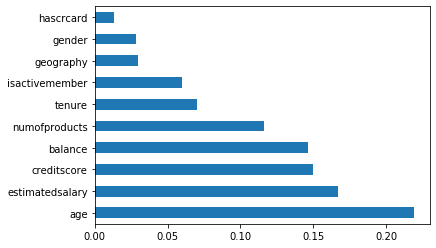

In [15]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(13).plot(kind='barh')

In [16]:
print(confusion_matrix(y_val, predictions_valid))

[[691 105]
 [100 104]]


In [17]:
print(f1_score(y_val, predictions_valid))

0.5036319612590799


Дерево решений без настройки показало неплохой резуьтат. Этому методу, на мой взгляд, "мешают" признаки hascard, gender, geography. Их будет необходимо откинуть на тестовом обучении. Теперь сделаю все тоже самое для рандомного леса

In [18]:
model = RandomForestClassifier(random_state=12345)
model.fit(X_train, y_train)
predictions_valid = model.predict(X_val)

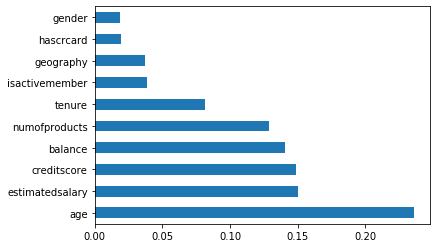

In [19]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(13).plot(kind='barh')

In [20]:
print(confusion_matrix(y_val, predictions_valid))

[[762  34]
 [119  85]]


In [21]:
print(f1_score(y_val, predictions_valid))

0.5263157894736842


Случайный лес показал значение лучше, этому методу, на мой взгляд, "мешают" признаки hascard, gender, geography, isactivemember, tenure. теперь время логистической регрессии

In [22]:
model = LogisticRegression(random_state=12345)
model.fit(X_train, y_train)
predictions_valid = model.predict(X_val)

In [23]:
names_of_variables =np.array(X_train.columns)
weights = model.coef_
weights

array([[-8.27934340e-04,  5.60669131e-02, -5.39418559e-01,
         7.14259272e-02, -1.50888595e-02,  2.06056363e-01,
        -1.26933843e-01, -6.02575918e-03, -1.10755513e+00,
         2.07102195e-02]])

In [24]:
print(confusion_matrix(y_val, predictions_valid))

[[776  20]
 [172  32]]


In [25]:
print(f1_score(y_val, predictions_valid))

0.25


Уже во второй раз логистическая регрессия расстраивает меня:( Далее необходимо посмотреть на балнс классов. возможно поможет оставить только age, estimatedsalary и balance. этот метод нашел в интернете, не уверен что я правильно его интерпретирую, но попробовать стоит

In [26]:
y_train.value_counts(normalize=True)

0.0    0.79625
1.0    0.20375
Name: exited, dtype: float64

Соотношение классов 80-20, что не очень хорошо. 

#### Выводы

- Были оценены значения F1 меры на трех моделях - дерево решений, случайный лес и логистическая регрессия
- Лучше всего себя показал случайный лес, хуже всего - логистическая регрессия
- Баланс классов составляет соотношение 80% данных - это данные о клиентах, которые не покидают банк, 20% - данные "перебежчиков"
- Были найдены мешающие признаки для каждой модели

# 3. Борьба с дисбалансом

Самое простое, что я запомнил из тренажера - это увеличение объема выборки. Поэтому для начала было решено ипользовать именно его. Ниже описана функция, которая увеличивает объем выборки и перемешивает данные.

In [27]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Увеличваю обучающую выборку в 10 раз

In [28]:
X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, 10)

Проверяю корректность работы выборки

In [29]:
X_train_upsampled.shape

(22670, 10)

Проделываю те же действия, как и в предидущем пункте для оценки значений

In [30]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(X_train_upsampled, y_train_upsampled)
predictions_valid = model.predict(X_val)

In [31]:
print(confusion_matrix(y_val, predictions_valid))

[[704  92]
 [ 95 109]]


In [32]:
print(f1_score(y_val, predictions_valid))

0.5382716049382716


In [33]:
model = RandomForestClassifier(random_state=12345)
model.fit(X_train_upsampled, y_train_upsampled)
predictions_valid = model.predict(X_val)

In [34]:
print(confusion_matrix(y_val, predictions_valid))

[[744  52]
 [104 100]]


In [35]:
print(f1_score(y_val, predictions_valid))

0.5617977528089888


In [36]:
model = LogisticRegression(random_state=12345)
model.fit(X_train_upsampled, y_train_upsampled)
predictions_valid = model.predict(X_val)

In [37]:
print(confusion_matrix(y_val, predictions_valid))

[[253 543]
 [ 14 190]]


In [38]:
print(f1_score(y_val, predictions_valid))

0.4055496264674493


Как можно увидеть, во всех трех случаях значения F1-меры выросло, особенно на логистической регрессии. Необходимо произвести тюнинг моделей для поиска оптимальных значений и переходить к тестированию.

In [ ]:
%%time
param_grid={'max_depth': [deep for deep in range (2, 20)]}
gs_dt = GridSearchCV(DecisionTreeClassifier(random_state=12345), param_grid=param_grid)
gs_dt.fit(X_train, y_train)
gs_dt.best_params_

In [ ]:
%%time
param_grid={'max_depth': [deep for deep in range (2, 10)],
           'n_estimators': [n_est for n_est in range (10, 100, 10)]}
gs_rf = GridSearchCV(RandomForestClassifier(random_state=12345), param_grid=param_grid)
gs_rf.fit(X_train_upsampled, y_train_upsampled)
gs_rf.best_params_

In [ ]:
%%time
param_grid={'penalty': ['l1', 'l2'],
           'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
gs_lr = GridSearchCV(LogisticRegression(random_state=12345), param_grid=param_grid)
gs_lr.fit(X_train, y_train)
gs_lr.best_params_

#### Выводы
- Было произведено увеличение обучающей выборки
- F1-мера увеличилась на всех трех моделях
- Выбранные гиперпараметры для моделей:
    - Дерево решений: глубина = 5
    - Случайный лес: глубина = 9, количество деревьев = 50
    - Логистическая регрессия: l2, С = 0.8

# 4. Тестирование модели

На этом этапе производится оценка моделей на тестовых данных, а также оценка значений площади AUC-ROC кривой и F1-меры. Так же для каждой модели передается значение class_weight='balanced', что позволяет  алгоритму посчитать, во сколько раз
класс «0» встречается чаще класса «1».

In [40]:
X_train_fs_tree = X_train[['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'isactivemember', 'estimatedsalary']]
X_test_fs_tree = X_test[['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'isactivemember', 'estimatedsalary']]

X_train_fs_rf = X_train[['creditscore', 'age', 'balance', 'numofproducts', 'estimatedsalary']]
X_test_fs_rf = X_test[['creditscore', 'age', 'balance', 'numofproducts', 'estimatedsalary']]

X_train_fs_lr = X_train[['age','estimatedsalary', 'balance']]
X_test_fs_lr = X_test[['age','estimatedsalary', 'balance']]

In [41]:
model = DecisionTreeClassifier(class_weight='balanced',random_state=12345, max_depth=5)
model.fit(X_train, y_train)
predictions_test = model.predict(X_test)
score = model.score(X_test, y_test)
print('Точность классификации на тестовой выборке:{}'.format(score))
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('Точность:{}'.format(recall_score(y_test, predictions_test)))
print('Полнота:{}'.format(precision_score(y_test, predictions_test)))
print('Площадь AUC-ROC кривой:{}'.format(auc_roc))
print('F1-мера:{}'.format(f1_score(y_test, predictions_test)))

Точность классификации на тестовой выборке:0.757
Точность:0.729064039408867
Полнота:0.44047619047619047
Площадь AUC-ROC кривой:0.827991050182025
F1-мера:0.549165120593692


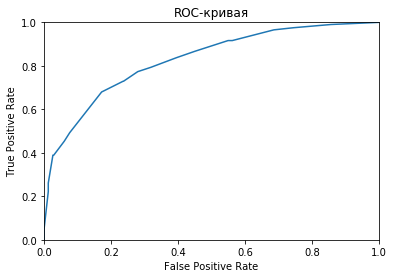

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [43]:
model = DecisionTreeClassifier(class_weight='balanced',random_state=12345, max_depth=5)
model.fit(X_train_fs_tree, y_train)
predictions_test = model.predict(X_test_fs_tree)
score = model.score(X_test_fs_tree, y_test)
print('Точность классификации на тестовой выборке:{}'.format(score))
probabilities_test = model.predict_proba(X_test_fs_tree)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('Точность:{}'.format(recall_score(y_test, predictions_test)))
print('Полнота:{}'.format(precision_score(y_test, predictions_test)))
print('Площадь AUC-ROC кривой:{}'.format(auc_roc))
print('F1-мера:{}'.format(f1_score(y_test, predictions_test)))

Точность классификации на тестовой выборке:0.782
Точность:0.7142857142857143
Полнота:0.47540983606557374
Площадь AUC-ROC кривой:0.8292148512587226
F1-мера:0.5708661417322834


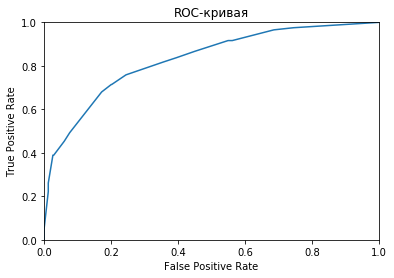

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Для модели решающего дерева без удаления неинформативных признаков эти значения следущие:
- Точность классификации на тестовой выборке:0.757
- Точность:0.729064039408867
- Полнота:0.44047619047619047
- Площадь AUC-ROC кривой:0.827991050182025
- F1-мера:0.549165120593692

Для модели решающего дерева с удалением неинформативных признаков эти значения следущие:
- Точность классификации на тестовой выборке:0.782
- Точность:0.7142857142857143
- Полнота:0.47540983606557374
- Площадь AUC-ROC кривой:0.8292148512587226
- F1-мера:0.5708661417322834

Значения точности классификации, полноты, F1-меры и площадь под кривой выросли после удаления неинформаивных признаков, но точность уменьшилась

In [45]:
model = RandomForestClassifier(class_weight='balanced',random_state=12345, n_estimators=50, max_depth=9)
model.fit(X_train, y_train)
predictions_test = model.predict(X_test)
score = model.score(X_test, y_test)
print('Точность классификации на тестовой выборке:{}'.format(score))
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('Площадь AUC-ROC кривой:{}'.format(auc_roc))
print('Точность:{}'.format(recall_score(y_test, predictions_test)))
print('Полнота:{}'.format(precision_score(y_test, predictions_test)))
print('F1-мера:{}'.format(f1_score(y_test, predictions_test)))

Точность классификации на тестовой выборке:0.823
Площадь AUC-ROC кривой:0.8582492227627
Точность:0.6945812807881774
Полнота:0.55078125
F1-мера:0.6143790849673202


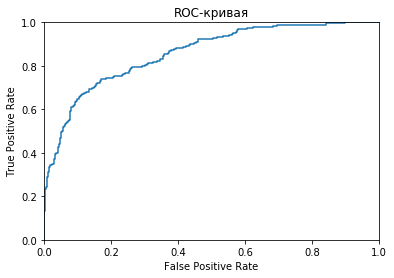

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [47]:
model = RandomForestClassifier(class_weight='balanced',random_state=12345, n_estimators=50, max_depth=9)
model.fit(X_train_fs_rf, y_train)
predictions_test = model.predict(X_test_fs_rf)
score = model.score(X_test_fs_rf, y_test)
print('Точность классификации на тестовой выборке:{}'.format(score))
probabilities_test = model.predict_proba(X_test_fs_rf)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('Площадь AUC-ROC кривой:{}'.format(auc_roc))
print('Точность:{}'.format(recall_score(y_test, predictions_test)))
print('Полнота:{}'.format(precision_score(y_test, predictions_test)))
print('F1-мера:{}'.format(f1_score(y_test, predictions_test)))

Точность классификации на тестовой выборке:0.797
Площадь AUC-ROC кривой:0.8478963601189189
Точность:0.7093596059113301
Полнота:0.5
F1-мера:0.5865580448065173


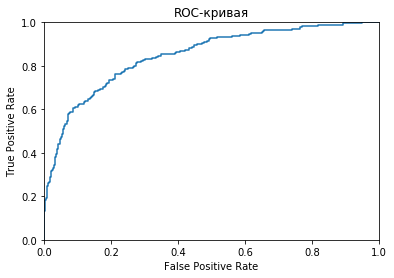

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Для модели случайного леса без удаления неинформативных признаков эти значения следущие:
- Точность классификации на тестовой выборке:0.823
- Площадь AUC-ROC кривой:0.8582492227627
- Точность:0.6945812807881774
- Полнота:0.55078125
- F1-мера:0.6143790849673202

Для модели случайного леса с удалением неинформативных признаков эти значения следущие:
- Точность классификации на тестовой выборке:0.797
- Площадь AUC-ROC кривой:0.8478963601189189
- Точность:0.7093596059113301
- Полнота:0.5
- F1-мера:0.5865580448065173

После удаления неинформативных признаков значение точности увеличилась, все остальные метрики уменьшились

In [49]:
model = LogisticRegression(class_weight='balanced',random_state=12345, C=0.8, penalty='l2')
model.fit(X_train, y_train)
predictions_test = model.predict(X_test)
score = model.score(X_test, y_test)
print('Точность классификации на тестовой выборке:{}'.format(score))
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('Площадь AUC-ROC кривой:{}'.format(auc_roc))
print('Точность:{}'.format(recall_score(y_test, predictions_test)))
print('Полнота:{}'.format(precision_score(y_test, predictions_test)))
print('F1-мера:{}'.format(f1_score(y_test, predictions_test)))

Точность классификации на тестовой выборке:0.695
Площадь AUC-ROC кривой:0.765994400182952
Точность:0.729064039408867
Полнота:0.37185929648241206
F1-мера:0.49251247920133107


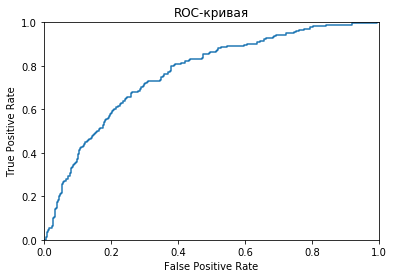

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [51]:
model = LogisticRegression(class_weight='balanced',random_state=12345, C=0.8, penalty='l2')
model.fit(X_train_fs_lr, y_train)
predictions_test = model.predict(X_test_fs_lr)
score = model.score(X_test_fs_lr, y_test)
print('Точность классификации на тестовой выборке:{}'.format(score))
probabilities_test = model.predict_proba(X_test_fs_lr)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('Площадь AUC-ROC кривой:{}'.format(auc_roc))
print('Точность:{}'.format(recall_score(y_test, predictions_test)))
print('Полнота:{}'.format(precision_score(y_test, predictions_test)))
print('F1-мера:{}'.format(f1_score(y_test, predictions_test)))

Точность классификации на тестовой выборке:0.723
Площадь AUC-ROC кривой:0.7565686595669722
Точность:0.7044334975369458
Полнота:0.3972222222222222
F1-мера:0.5079928952042628


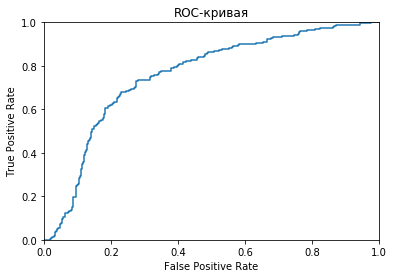

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Для модели логистической регрессии без удаления неинформативных признаков эти значения следущие:
- Точность классификации на тестовой выборке:0.695
- Площадь AUC-ROC кривой:0.765994400182952
- Точность:0.729064039408867
- Полнота:0.37185929648241206
- F1-мера:0.49251247920133107

Для модели логистической регрессии с удалением неинформативных признаков эти значения следущие:
- Точность классификации на тестовой выборке:0.723
- Площадь AUC-ROC кривой:0.7565686595669722
- Точность:0.7044334975369458
- Полнота:0.3972222222222222
- F1-мера:0.5079928952042628

После удаления неинформативных признаков значения точности классификации, полноты и F1-меры увеличились. Значения площади под кривой и точности уменьшились

# Выводы
- На этапе подготовки данных были заполнены пропуски медианой по столбцу. Затем категориальные данные были закодированы и необходимые признаки промасштабированы. затем выборка была разбита в соотношении 80-10-10
- На этапе Исследования задачи были оценены F1-меры на всех ненастроеных моделях и найден текущий баланс классов
- На этапе избавления от дисбаланса был проведен апсемплинг данных и повторно оценена F1-мера, которая выросла, а так же найдены оптимальные гиперпараметры для моделей
- На этапе тестирования для моделей добавлен параметр class_weight='balanced' для моделей и оценена площадь AUC-ROC кривой и F1-мера. Лучше всего показал себя <b>алгоритм случайного леса (0.8625881538528101 и 0.6287015945330295 соответственно)</b>, второе место заняло дерево решений (0.827104103442095 и 0.5481481481481482 соответственно), хуже всех проявила себя линейная регрессия (0.7655493816096074 и 0.4891122278056951 соответственно) 

### Дополнительные выводы
Попробовал удалить неинформативные признаки с помощью feature_importances_ для "деревянных" алгоритмов, но хороших результатов добиться не получилось, так как целевая метрика либо не достигла нужного уровня, либо вообще ухудшилась. Для линейной регрессии смог найти метод нахождения информативных признаков при помощи весов, но возможно не правильно его интерпретировал. Все результаты представлены в соответсвующих блоках (все таки нахождение нужных признаков по моему должно располагаться в исследовании задачи:). Тема future slection мне очень интересна, но пока что нет времени и сил нормально в ней разобраться) так же добавил метрики полноты и точности.  